# Clasificación Binaria de Imágenes usando Redes Neuronales Convolucionales

## Dataset: Aedes Aegipty y Aedes Albopictus

In [1]:
import os
import path
import shutil
import zipfile

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import classification_report, confusion_matrix

Estaremos trabajando con Pytorch, por lo que es necesario comprobar que se esté usando nuestra GPU.

Establecemos la semilla aleatoria de manera manual si usamos CPU o le encargamos a CUDA que establezca la misma semilla si se usa GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

We're using => cuda


Aquí definimos la ruta base de nuestros datos.

In [3]:
Path = "../Práctica 1/" #Depende de la ruta en tu máquina

In [12]:
with zipfile.ZipFile(Path+'DataSetAedes.zip', 'r') as archive:
   # Extrae todo el contenido del achivo ZIP en el directorio actual
   archive.extractall(Path)

In [13]:
os.listdir(Path+"DataSetAedes")

['Aegypti', 'Albopictus', 'Ambos', 'DataSetAedes']

## Definimos las transformaciones de las imágenes

Definamos un diccionario para contener las transformaciones de imagen para conjuntos de entrenamiento, prueba y validación

Cambiaremos el tamaño de todas las imágenes para que tengan tamaño (224, 224) y también convertiremos las imágenes a tensor.

La función `ToTensor` de Pytorch convuierte todos los tensores para que se encuentren entre (0, 1)

Esta función convierte una imagen PIL o un array de numpy `numpy.ndarray` de forma (H x W x C) "Height x Width x Channel" en el rango [0, 255] a un tensor de flotantes de Pytorch `torch.FloatTensor` de la forma (C x H x W) en el rango [0.0, 1.0]

In [14]:
image_transforms = { "train": transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()]),
                     "test": transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()]),
                     "val": transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])}


Usaremos la librería `splitfolder` para poder separar nuestros datos en train, test y validation de manera automática.

In [15]:
import splitfolders
os.makedirs(Path+"data", exist_ok=True)

splitfolders.ratio(Path+"DataSetAedes", output= Path+"data", seed=1, ratio=(.8, 0.1,0.1), group_prefix=2)


Copying files: 548 files [00:04, 130.20 files/s]


In [16]:
os.listdir(Path+"data")

['test', 'train', 'val']

Para esta actividad específicamente, no tomaremos en cuenta la carpeta de archivos que contiene los collages de ambas especies de mosquitos. Las usaremos en otra ocación.

In [17]:
for folders in os.listdir(Path+"data"):
    shutil.rmtree(Path+"data/"+folders+"/"+ "Ambos")
    os.rmdir(Path+"data/"+folders+"/"+ "DataSetAedes")

## Trabajando con los Datasets

Aquí inicializamos los Datasets usando las carpetas correspondientes y aplicamos sus transformaciones.

In [18]:
mosquitos_dataset_train = datasets.ImageFolder(root = Path + "data/train/",
                                         transform = image_transforms["train"])

mosquitos_dataset_test = datasets.ImageFolder(root = Path + "data/test/",
                                         transform = image_transforms["test"])

mosquitos_dataset_val = datasets.ImageFolder(root = Path + "data/val/",
                                         transform = image_transforms["val"])

print(mosquitos_dataset_train)
print(mosquitos_dataset_test)
print(mosquitos_dataset_val)

Dataset ImageFolder
    Number of datapoints: 416
    Root location: ../Práctica 1/data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 52
    Root location: ../Práctica 1/data/test/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 52
    Root location: ../Práctica 1/data/val/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
           )


La función class_to_idx está predefinida en PyTorch. Devuelve los IDs de clase presentes en el conjunto de datos.

In [19]:
mosquitos_dataset_train.class_to_idx

{'Aegypti': 0, 'Albopictus': 1}

Ahora haremos un mapeo de ID a clase.

In [20]:
idx2class = {v: k for k, v in mosquitos_dataset_train.class_to_idx.items()}

Ahora haremos una función que tomará un objeto de clase Dataset y regresará un diccionário con el conteo de muestras d clase. Usaremos este diccionario para contruir unas gráficas y observar la distrubución de clases de nuestros datos. 

La función `get_class_distribution()` recibe un argumento llamado `dataset_obj`

- Primero inicializamos el diccionario `count_dict` donde el conteo de todas nuestras claces comienza en 0

- Después, iteraremos a través de todo el dataset e iremos incrememntando el contador por 1 por cada que nos encontremmos con una nueva clase.

`plot_from_dict()` recibe 3 argumentos: un diccionario `dict_obj`, `plot_title`, y `**kwargs` que serán usados después para contruir subgráficas usando Seaborn

- Primero convertimos el diccionario en un dataframe

- Juntamos el dataframe y hacemos la gráfica

Text(0.5, 1.0, 'Dataset train elements)')

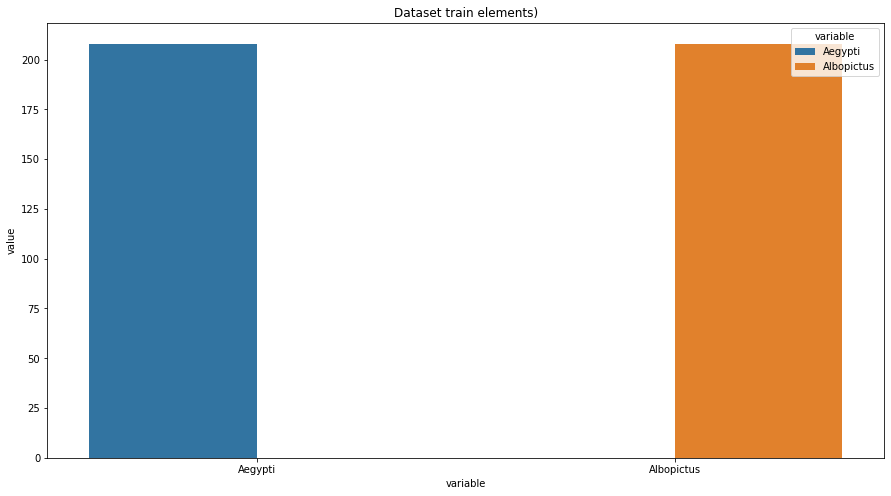

In [21]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(mosquitos_dataset_train), plot_title="Dataset train elements)")

Creamos los Dataloaders para cada uno de nuestros sets procurando poner la opción de `shuffle=True`para que nuestras imágenes no se encuentren en un orden específico

In [24]:
train_loader = DataLoader(dataset=mosquitos_dataset_train, shuffle=True, batch_size=8)

test_loader = DataLoader(dataset=mosquitos_dataset_test, shuffle=True, batch_size=1)

val_loader = DataLoader(dataset=mosquitos_dataset_val, shuffle=True, batch_size=1)

## Explorando las imágenes

Una vez cargados nuetros Datasets, podemos explorarlos un poco. Para ellos, creamos una función que tomará los dataloaders y regresarpa un diccionario con el conteo de clases, parecido al creado anteriormente.

- Inicializamos un diccionario `count_dict` con puros 0's

- Si el `batch_size` de `dataloader_obj` es 1, entonces recorre el `dataloader_obj` y actualiza el contador.

- Si el `batch_size` de `dataloader_obj` NO es 1, entonces recorre el `dataloader_obj` para obtener el tamaño de ls batches. Después recorre los batches para obtener los tensores individuales. Después, actualiza el contador.

In [25]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict

Ahora mostraremos la distribución de clases usando la función `plot_from_dict()` que definimsos anterioirmente.

Text(0.5, 1.0, 'Val Set')

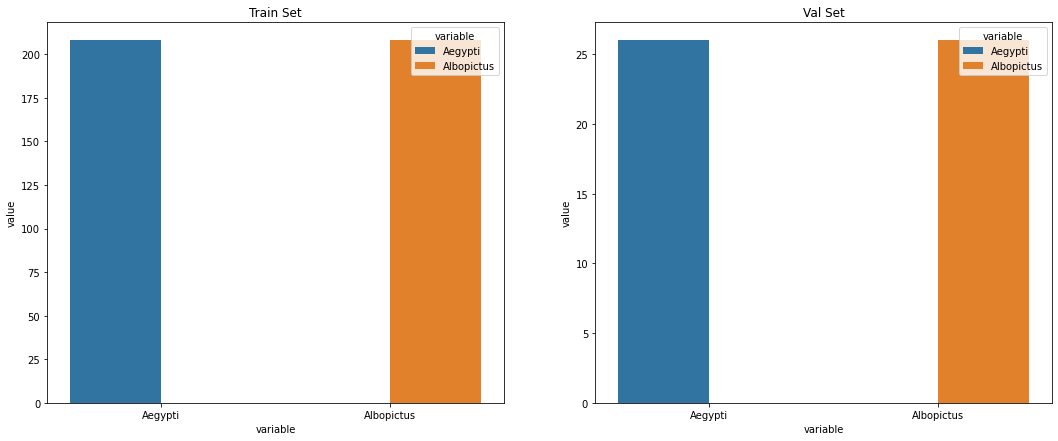

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
plot_from_dict(get_class_distribution_loaders(train_loader, mosquitos_dataset_train), plot_title="Train Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(val_loader, mosquitos_dataset_val), plot_title="Val Set", ax=axes[1])


Ahora que hemos comprobado la distibución de clases, veremos una sola imagen.

In [29]:
single_batch = next(iter(train_loader))

`single_batch` es una lista de 2 elementos. El primero es el contiene el tensor de la imagen mientras que el segundo elemento tiene las etiquetas.

La forma del primer elemento del tensor es `(Batch, channels, height, width)`

In [30]:
single_batch[0].shape

torch.Size([8, 3, 224, 224])

Y estas son las etiquetas de salida de los batches

In [31]:
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

Output label tensors:  tensor([1, 1, 1, 1, 0, 0, 1, 0])

Output label tensor shape:  torch.Size([8])


Para mostrar la imagen, usaremos `plt.imsow` de matplotlib. La función espera que las dimensiones de la imagen sean `(height, width, channels)`. Usaremos la función de `.permute()` en el tensor para poder "voltear" las dimensiones y poder mostrarla en una gráfica.

In [32]:
single_image = single_batch[0][0]
single_image.shape

torch.Size([3, 224, 224])

Definimos el estilo de Seaborn

In [40]:
%matplotlib inline
sns.set_style('darkgrid')

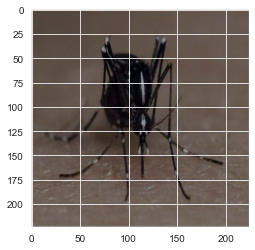

In [41]:
plt.imshow(single_image.permute(1, 2, 0))

PyTorch nos ha facilitado trazar las imágenes en una cuadrícula directamente desde el batch.

Primero extraemos el tensor de imagen de la lista (devuelto por nuestro dataloader) y establecemos `nrow`. Luego usamos la función `plt.imshow()` para graficar nuestra cuadrícula. No olvidemos la función `.permute()` para trabajar con las dimensiones del tensor conrrectas.

In [ ]:
# We do single_batch[0] because each batch is a list 
# where the 0th index is the image tensor and 1st index is the output label.
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

# Definir la arquitectura de la CNN

Nuestra arquitectura es simple. Usamos 4 bloques de capas Convolucionales. Cada bloque consiste en las siguientes capas; 

`Convolución` + `BatchNorm` + `ReLU` + `Dropout`

In [43]:
class MosquitosClassifier(nn.Module):
    def __init__(self):
        super(MosquitosClassifier, self).__init__()
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block

Ahora inicializaremos el modelo, el optimizador y la función de pérdida.

Luego, transferiremos el modelo a la GPU.
 
Usaremos la `nn.CrossEntropyLoss` aunque es un problema de clasificación binaria. Esto significa que, en lugar de devolver una única salida de `0/1`, trataremos la devolución de 2 valores de `0 a 1`. Más específicamente, las probabilidades de que la salida sea `0` o `1`.

No tenemos que aplicar manualmente una capa `log_softmax` después de nuestra capa final porque la `nn.CrossEntropyLosshace` por nosotros.

Pero debemos aplicar la capa `log_softmax` para la valicadión y prueba final.

In [ ]:
model = MosquitosClassifier()
model.to(device)
print(model)
optimizer = optim.SGD(model.parameters(), lr=0.008)
criterion = nn.CrossEntropyLoss()

Antes de comenzar nuestro entrenamiento, definamos una función para calcular la precisión por época.

Esta función toma `y_pred` y `y_testcomo` argumentos de entrada. Luego aplicamos softmax `y_predy` extraemos la clase que tiene una mayor probabilidad.

Después de eso, comparamos las clases predichas y las clases reales para calcular la precisión.

In [45]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

También definiremos 2 diccionarios que almacenarán la precisión/época y la pérdida/época para los conjuntos de entrenamiento y validación.

In [46]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

Hemos puesto un `model.train()` antes del bucle. `model.train()` le dice a PyTorch que estás en modo de entrenamiento. Bueno, ¿por qué tenemos que hacer eso? Si está usando capas como `Dropout` o `BatchNorm` que se comportan de manera diferente durante el entrenamiento y la evaluación (por ejemplo; no usar dropoutdurante la evaluación), debe decirle a PyTorch que actúe en consecuencia. Si bien el modo predeterminado en PyTorch es el entremaniento, no es necesario que lo escriba explícitamente. Pero es buena práctica.

De manera similar, llamaremos `model.eval()` cuando probemos nuestro modelo. Lo veremos a continuación. Regresando con el entrenamiento; comenzamos un ciclo for. En la parte superior de este ciclo for, inicializamos nuestra `loss` y `accuracy` por época en 0. Después de cada época, imprimiremos la `loss/accuracy` y la restableceremos a 0.

Luego tenemos otro ciclo for. Este bucle for se utiliza para obtener nuestros datos batches de `train_loader`.

Aplicamos `optimizer.zero_grad()` antes de hacer predicciones. Dado que la función `.backward()` acumula gradientes, debemos establecerla en 0 manualmente por minibatches. A partir de nuestro modelo definido, obtenemos una predicción, obtenemos la `loss` (y `accuracy`) para ese minibatch, realizamos la propagación hacia atrás usando `loss.backward()` y `optimizer.step()`.

Finalmente, agregamos todas las `loss` (y `accuracy`) de minibatches para obtener la pérdida promedio (y precisión) para esa época. Sumamos todas las `loss/accuracy` para cada minibatch y finalmente lo dividimos por el número de minibatches, es decir, longitud del `trainloader` para obtener la `loss/accuracy` promedio por época.

El procedimiento que seguimos para el entrenamiento es exactamente el mismo para la validación, excepto por el hecho de que lo concluimos con la función `torch.no_grad` y no realizamos ninguna propagación hacia atrás. `torch.no_grad` le dice a PyTorch que no queremos realizar una retropropagación, lo que reduce el uso de memoria y acelera el cálculo.

In [47]:
print("Begin training.")
for e in tqdm(range(1, 21)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 32.65693 | Val Loss: 7.06386 | Train Acc: 51.942| Val Acc: 53.846
Epoch 02: | Train Loss: 3.75884 | Val Loss: 1.24002 | Train Acc: 59.365| Val Acc: 63.462
Epoch 03: | Train Loss: 1.17469 | Val Loss: 0.60606 | Train Acc: 68.500| Val Acc: 76.923
Epoch 04: | Train Loss: 0.69816 | Val Loss: 0.55553 | Train Acc: 73.327| Val Acc: 71.154
Epoch 05: | Train Loss: 0.50307 | Val Loss: 0.51505 | Train Acc: 77.000| Val Acc: 76.923
Epoch 06: | Train Loss: 0.42064 | Val Loss: 0.55578 | Train Acc: 82.596| Val Acc: 84.615
Epoch 07: | Train Loss: 0.52399 | Val Loss: 0.51331 | Train Acc: 80.154| Val Acc: 75.000
Epoch 08: | Train Loss: 0.42585 | Val Loss: 0.42226 | Train Acc: 80.923| Val Acc: 75.000
Epoch 09: | Train Loss: 0.35749 | Val Loss: 0.67169 | Train Acc: 86.250| Val Acc: 73.077
Epoch 10: | Train Loss: 0.37572 | Val Loss: 0.38241 | Train Acc: 84.481| Val Acc: 86.538
Epoch 11: | Train Loss: 0.30625 | Val Loss: 0.37076 | Train Acc: 89.096| Val Acc: 90.385
Epoch 12: | Train Lo

## Visualizar la pérdida y la precisión

Para trazar las gráficas de pérdida y precisión, nuevamente creamos un dataframe a partir de los diccionarios `accuracy_stats` y `loss_stats`.

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

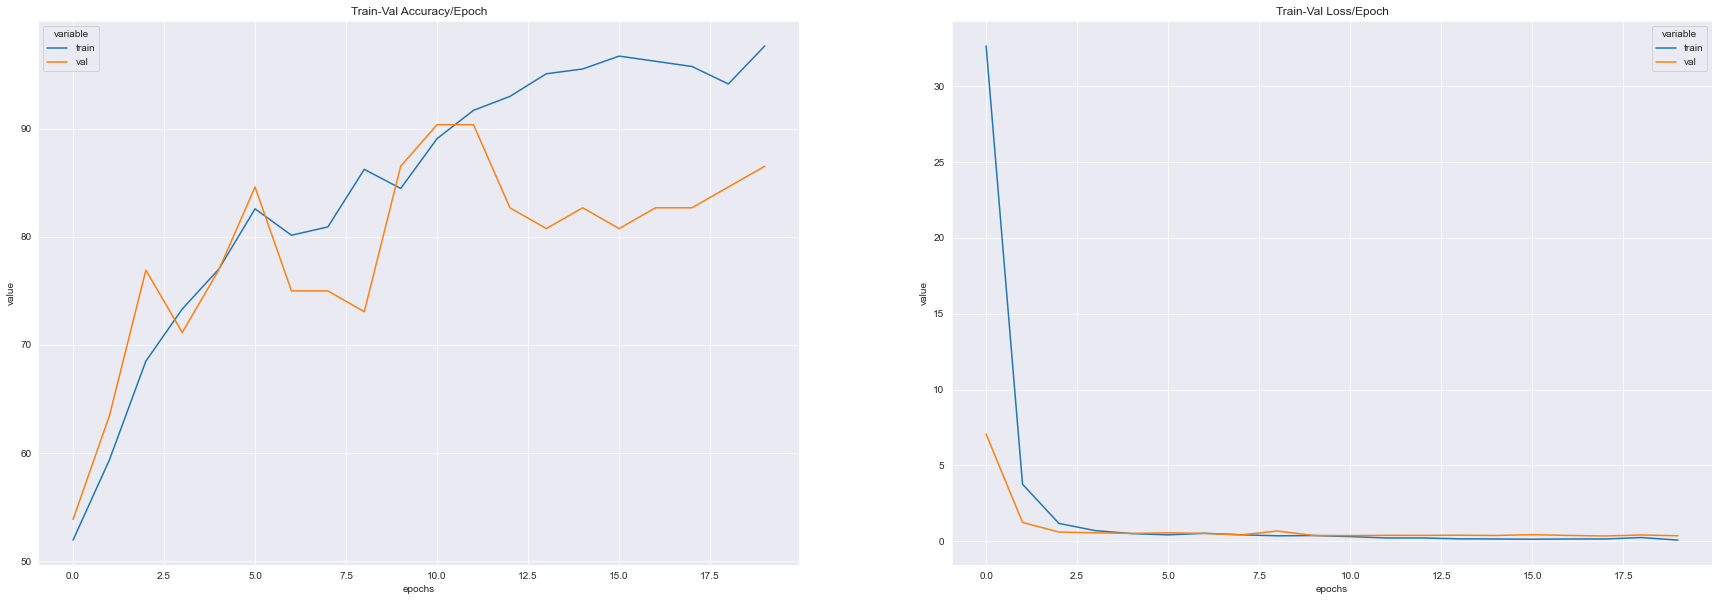

In [48]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## Prueba del modelo

Después del entrenamiento, debemos comprobar cómo se comporta nuestro modelo. Usaremos `model.eval()` antes de correr nuetro códido de prueba. 

Para decirle a PyTorch que no queremos realizar una retropropagación durante la inferencia, usamos `torch.no_grad()`, tal como lo hicimos para el ciclo de validación anterior.

- Comenzamos una lista que va a tener nuestras predicciones Entonces iteramos a travéz de nuestros batches usando `test_loader`. Para cada batch:

    - Movemos nuestros mini bacthes de entrada la la GPU
    
    - Hacemos nuestras predicciones en nuestro modelo entrenado.
    
    - Aplicamos la función de activación `log_softmax` a las predicciones y legimos el índice del que tenga la mayor probabilidad
    
    - Movemos el batch de la GPU  a la CPU.
    
    - Convertimos el tensor a un objeto de nunpy y lo agregamos a nuestra lista.

In [49]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/52 [00:00<?, ?it/s]

Aplanaremos la lista para que podamos usarla como entrada para `confusion_matrix()` y `classification_report()`

In [50]:
y_pred_list = [i[0][0][0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

## Reporte de clasificaión

Finalmente, mostramos nuestro reporte de clasificación que contiene la precisión, el recall y la puntuación F1.

In [51]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.86      0.73      0.79        26
           1       0.77      0.88      0.82        26

    accuracy                           0.81        52
   macro avg       0.82      0.81      0.81        52
weighted avg       0.82      0.81      0.81        52



## Matriz de Confusión

Usaremos la función `confusion_matrix()` para realizar nuestra matris de confusión.

In [52]:
print(confusion_matrix(y_true_list, y_pred_list))

[[19  7]
 [ 3 23]]


Creamos un dataframe de la matriz de confusión y lo graficamos en un mapa de calor usando la lirería de Seaborn.

<AxesSubplot:>

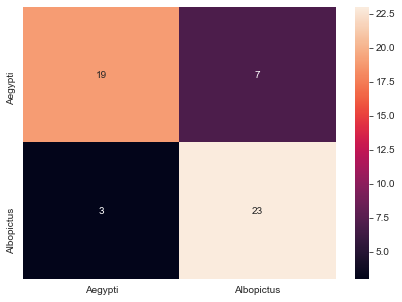

In [53]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)
